# `intake-esm` multi-var files
`intake-esm` is mostly used for cmorized files containing one variable over many years.
However, the standard output from `MPI-ESM1-2-LR` is stored in one-year files with many variables.
`intake-esm` can also open these data structures.

This notebook applies https://intake-esm.readthedocs.io/en/latest/user-guide/multi-variable-assets.html to MPI-ESM1-2-LR standard output.

In [ ]:
import os
import subprocess
from tqdm.auto import tqdm
from pathlib import Path
import shutil
import dask.dataframe as dd
import fnmatch
import pandas as pd
import cdo
cdo=cdo.Cdo()

In [2]:
# basepath for all your experiments
exp_path = '/work/bm1124/m300524/experiments'

In [24]:
persist_path='filenames'

shutil.rmtree(persist_path)

In [25]:
def get_file_list(exppath,expids,persist_path):
    persist_path = Path(persist_path)
    persist_path.mkdir(exist_ok=True)
    for expid in tqdm(expids):
        p = f'{exppath}/{expid}/outdata/'
        if not os.path.exists(p):
            continue
        root = Path(p)
        dirs = [x for x in root.iterdir() if (x.is_dir() and x not in ['oasis','cvdp'])]
        for directory in dirs:
            stem = directory.stem
            if stem in ['jsbach','echam6','mpiom','hamocc']:
                #print(directory,stem)
                f = open(f"{persist_path}/{stem}.txt", "a")
                for ending in ['nc','grb']:
                    cmd = ["find", "-L", directory.as_posix(), "-name", f"*.{ending}"]
                    p = subprocess.Popen(cmd, stderr=subprocess.PIPE, stdout=f)
                    p.wait()

In [26]:
#expids = ['vga0220a_Rerun','asp_PMassim_reconvga0220a_Rerun_init1896_m004','asp_PMassim_reconvga0220a_Rerun_init1896_m003']

In [27]:
expids = !ls /work/bm1124/m300524/experiments

In [28]:
# loop over all experiments and collect paths
get_file_list(exp_path, expids, persist_path)

In [29]:
df = dd.read_csv(f"{persist_path}/*.txt", header=None).compute()
df.columns = ["path"]
df.head()

path
0  /work/bm1124/m300524/experiments/asp_esmContro...
1  /work/bm1124/m300524/experiments/asp_esmContro...
2  /work/bm1124/m300524/experiments/asp_esmContro...
3  /work/bm1124/m300524/experiments/asp_esmContro...
4  /work/bm1124/m300524/experiments/asp_esmContro...

In [31]:
%%time
# exclude paths, here cmorized variables by c6_cmor_land.sh
exclude_patterns = ['*Lmon*']

def _filter_func(path):
    return not any(
        fnmatch.fnmatch(path, pat=exclude_pattern) for exclude_pattern in exclude_patterns
    )

files = df.path.tolist()
filelist = list(filter(_filter_func, files))

CPU times: user 272 ms, sys: 18 ms, total: 290 ms
Wall time: 846 ms


In [32]:
def get_attrs(filepath):
    """Get attributes based on filepath."""
    basename = os.path.basename(filepath)
    dirname = os.path.dirname(filepath)
    expid = dirname.split('/')[-3]
    model = dirname.split('/')[-1]
    ending = basename.split('.')[-1]
    f = basename.split('_')
    if ending == 'nc':
        time_range = '_'.join(f[-2:]).replace(f'.{ending}','')
        left = basename.replace(expid,'').replace(time_range,'').replace(f'.{ending}','')
        stream = left[1:-1]
    elif ending == 'grb':
        time_range = f[-1].replace(f".{ending}",'')
        left = basename.replace(expid,'').replace(time_range,'').replace(f'.{ending}','').replace(f"_{model}_","")
        stream = left[:-1]
    fileparts = {'experiment':expid, 'time_range':time_range, 'stream': stream}

    parent = os.path.dirname(filepath).strip('/')
    fileparts['institution_id'] = 'MPI-M'# part_1[-1]
    fileparts['source_id'] = 'MPI-ESM1-2-LR'
    fileparts['model']=model
    fileparts['grid_label']='gr' if model in ['jsbach','echam6'] else 'gn'
    fileparts['path'] = filepath
    return fileparts 

In [33]:
#filelist[-50]

In [34]:
#get_attrs(filelist[-30])

In [35]:
%%time
entries = list(map(get_attrs, filelist))

CPU times: user 511 ms, sys: 22 ms, total: 533 ms
Wall time: 532 ms


In [36]:
df1 = pd.DataFrame(entries)

df1.head()

experiment time_range     stream  \
0  asp_esmControl_PMassim_1850_ATM_over_2006       1866  tracer_mm   
1  asp_esmControl_PMassim_1850_ATM_over_2006       1862     LOG_mm   
2  asp_esmControl_PMassim_1850_ATM_over_2006       1860      echam   
3  asp_esmControl_PMassim_1850_ATM_over_2006       1889      echam   
4  asp_esmControl_PMassim_1850_ATM_over_2006       1879      echam   

  institution_id      source_id   model grid_label  \
0          MPI-M  MPI-ESM1-2-LR  echam6         gr   
1          MPI-M  MPI-ESM1-2-LR  echam6         gr   
2          MPI-M  MPI-ESM1-2-LR  echam6         gr   
3          MPI-M  MPI-ESM1-2-LR  echam6         gr   
4          MPI-M  MPI-ESM1-2-LR  echam6         gr   

                                                path  
0  /work/bm1124/m300524/experiments/asp_esmContro...  
1  /work/bm1124/m300524/experiments/asp_esmContro...  
2  /work/bm1124/m300524/experiments/asp_esmContro...  
3  /work/bm1124/m300524/experiments/asp_esmContro...  
4  /work/bm1124/m300524/experiments/asp_esmContro...

In [37]:
# remove wrong inputs manually
df1 = df1[df1.stream != '']
df1 = df1[df1.time_range != 'mm']

In [38]:
def strip_year(entry):
    entry['time_range'] = entry['time_range'][:4]
    return entry

%time df1 = df1.apply(lambda row: strip_year(row), axis=1)

CPU times: user 5.24 s, sys: 34 ms, total: 5.28 s
Wall time: 6.19 s


In [44]:
# add variable ids

def add_variable_ids(entry):
    model = entry['model']
    stream = entry['stream']
    expid = entry['experiment']
    ending = entry['path'].split('.')[-1]
    if model in ['jsbach','echam6'] and ending == 'grb':
        if stream in ['ATM','ATM_mm','LOG','LOG_mm','BOT_mm','BOT']:
            table = 'echam6'
        else:
            table = f'{exp_path}/{expid}/log/{expid}_{model}_{stream.replace("_mm","")}.codes'
            #print(f'use table {table}')
        options = f'-t {table}'
    else:
        options = ''
    #print(options,model,stream)
    variable_ids = cdo.showname(input=entry['path'],options=options)[0].split(' ')
    entry['variable']=variable_ids
    return entry

%time vars_by_stream = {s: add_variable_ids(df1[df1.stream==s].iloc[0])['variable'] for s in df1.stream.unique()}

CPU times: user 2.22 s, sys: 4.2 s, total: 6.42 s
Wall time: 35 s


In [45]:
def set_variables(entry):
    entry['variable'] = str(vars_by_stream[entry.stream])
    return entry

#%time df1=df1.apply(lambda row: add_variable_ids(row), axis=1)

%time df1 = df1.apply(lambda row: set_variables(row), axis=1)

CPU times: user 1min 2s, sys: 1.74 s, total: 1min 4s
Wall time: 1min 24s


In [46]:
df1.head()

experiment time_range     stream  \
0  asp_esmControl_PMassim_1850_ATM_over_2006       1866  tracer_mm   
1  asp_esmControl_PMassim_1850_ATM_over_2006       1862     LOG_mm   
2  asp_esmControl_PMassim_1850_ATM_over_2006       1860      echam   
3  asp_esmControl_PMassim_1850_ATM_over_2006       1889      echam   
4  asp_esmControl_PMassim_1850_ATM_over_2006       1879      echam   

  institution_id      source_id   model grid_label  \
0          MPI-M  MPI-ESM1-2-LR  echam6         gr   
1          MPI-M  MPI-ESM1-2-LR  echam6         gr   
2          MPI-M  MPI-ESM1-2-LR  echam6         gr   
3          MPI-M  MPI-ESM1-2-LR  echam6         gr   
4          MPI-M  MPI-ESM1-2-LR  echam6         gr   

                                                path  \
0  /work/bm1124/m300524/experiments/asp_esmContro...   
1  /work/bm1124/m300524/experiments/asp_esmContro...   
2  /work/bm1124/m300524/experiments/asp_esmContro...   
3  /work/bm1124/m300524/experiments/asp_esmContro...   
4  /work/bm1124/m300524/experiments/asp_esmContro...   

                                            variable  
0                                            ['CO2']  
1                                    ['t', 'u', 'v']  
2  ['st', 'svo', 'lsp', 'sd', 'q', 'xl', 'xi', 'r...  
3  ['st', 'svo', 'lsp', 'sd', 'q', 'xl', 'xi', 'r...  
4  ['st', 'svo', 'lsp', 'sd', 'q', 'xl', 'xi', 'r...

In [47]:
# number of files in catalog
df1.index.size

81679

In [48]:
df1.to_csv('my_exps.csv.gz', compression='gzip', index=False)

# data access with `intake-esm`

In [49]:
import intake
import ast
col = intake.open_esm_datastore(
    "/mnt/lustre01/pf/zmaw/m300524/intake-esm-datastore/my_exps.json",
    csv_kwargs={"converters": {"variable": ast.literal_eval}},
)
col

In [51]:
assert col._multiple_variable_assets

In [57]:
experiments = ['asp_esmControl_PMassim_1850_ATM_over_2006','asp_esmControl_PMassim_1850_TS_over_2006',
               'asp_esmControl_PMassim_1850_ATMTSI2_over_2006','asp_esmControl_PMassim_1850_ATMTSIDICALKlandr_over_2006','vga0220a_Rerun']

In [68]:
sub_col = col.search(variable=['fgco2','intpp'],experiment=experiments,
                     stream=['hamocc_data_2d_mm','mpiom_data_2d_mm'])
sub_col

In [69]:
ds_dict = sub_col.to_dataset_dict(cdf_kwargs={'chunks':-1})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'grid_label'


In [70]:
ds = ds_dict['gn']

In [71]:
print(ds)

<xarray.Dataset>
Dimensions:     (depth: 1, experiment: 4, grid_label: 1, time: 600, x: 256, y: 220)
Coordinates:
  * time        (time) datetime64[ns] 1850-01-31T23:15:00 ... 1899-12-31T23:1...
    lon         (y, x) float64 dask.array<chunksize=(220, 256), meta=np.ndarray>
    lat         (y, x) float64 dask.array<chunksize=(220, 256), meta=np.ndarray>
  * depth       (depth) float64 0.0
  * experiment  (experiment) <U45 'asp_esmControl_PMassim_1850_ATMTSI2_over_2...
  * grid_label  (grid_label) <U2 'gn'
Dimensions without coordinates: x, y
Data variables:
    intpp       (grid_label, experiment, time, depth, y, x) float32 dask.array<chunksize=(1, 1, 12, 1, 220, 256), meta=np.ndarray>
    fgco2       (grid_label, experiment, time, depth, y, x) float32 dask.array<chunksize=(1, 1, 12, 1, 220, 256), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.4
    CDI:                     Climate Data Interface version 1.7.0rc3 (http://...
    intake_esm_varname:      ['intpp', 'fgco

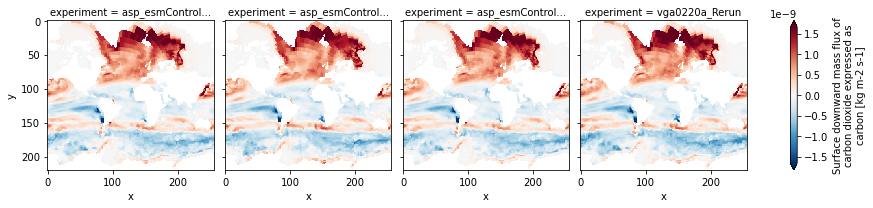

In [73]:
ds.sel(time='1860-05').fgco2.plot(col='experiment',robust=True, yincrease=False)